# HRRR Zarr Example Using XArray
## Download an analysis variable, whole grid, 24 hours

This example shows how to get a day's worth of analysis files for a single variable and combine them using high-level APIs.

[Download this notebook](https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/xarray_one_day_analysis_example.ipynb)

In [ ]:
import s3fs
import xarray as xr
import metpy
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

We use xarray's open_mfdataset to load the data. There's a couple things missing from the metadata, so we use a metpy extension to add projection info and latitude/longitude. We also promote the "time" attribute to a coordinate so that combining the datasets for each hour will work later on.

In [2]:
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

def load_dataset(urls):
    fs = s3fs.S3FileSystem(anon=True)
    ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in urls], engine='zarr')
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    ds = ds.metpy.assign_crs(projection.to_cf())
    ds = ds.metpy.assign_latitude_longitude()
    ds = ds.set_coords("time")
    return ds

The following function demonstrates how to format the urls to load the data, as well as how to combine the hours using xarray.concat. Note that because there's an extra level of nesting for the main data variable (level and variable name), we have to get both the zarr group url and the url for the nested subgroup. That's why we have to use open_mfdataset ("mf" means "multifile")––other zarr datasets likely won't have this quirk.

In [3]:
def load_combined_dataset(start_date, num_hours, level, param_short_name):
    combined_ds = None
    for i in range(num_hours):
        time = start_date + datetime.timedelta(hours=i)
        group_url = time.strftime(f"s3://hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_anl.zarr/{level}/{param_short_name}")
        subgroup_url = f"{group_url}/{level}"
        partial_ds = load_dataset([group_url, subgroup_url])
        if not combined_ds:
            combined_ds = partial_ds
        else:
            combined_ds = xr.concat([combined_ds, partial_ds], dim="time", combine_attrs="drop_conflicts")
    return combined_ds

Just for demonstration purposes, we load up the data and calculate the standard deviation so we have something to plot across the geospatial domain. Note that this whole thing takes a little over 1 min on my laptop, mostly spent on downloading the data. You may need some performance optimizations or parallelization if you're doing a large analysis.

In [13]:
%%time
ds = load_combined_dataset(datetime.datetime(2021, 4, 1), 24, "1000mb", "TMP")

CPU times: user 10.6 s, sys: 426 ms, total: 11 s
Wall time: 39.4 s


In [17]:
%%time
std_dev = ds.TMP.std(dim="time")
std_dev.values

CPU times: user 20.6 s, sys: 3.12 s, total: 23.7 s
Wall time: 34.5 s


array([[0.4785, 0.4756, 0.4583, ..., 0.288 , 0.288 , 0.288 ],
       [0.4446, 0.4446, 0.4297, ..., 0.288 , 0.288 , 0.288 ],
       [0.4446, 0.4446, 0.4446, ..., 0.288 , 0.288 , 0.288 ],
       ...,
       [0.552 , 0.567 , 0.6157, ..., 0.72  , 0.7563, 0.7466],
       [0.552 , 0.543 , 0.567 , ..., 0.7603, 0.7715, 0.749 ],
       [0.551 , 0.543 , 0.543 , ..., 0.759 , 0.78  , 0.834 ]],
      dtype=float16)

The data is loaded lazily, meaning only metadata saying what data exists (such as the grid, dataset attributes, and size and encoding of data) is downloaded just by "opening" the dataset. In fact, the actual data isn't downloaded even when we ask for the std deviation calculation to be done––the code just makes a note to calculate the std once the values are requested. So the time for std_dev.values to completely is almost entirely just the time for downloading the TMP data.

If we didn't print "values" here, the data wouldn't be downloaded until actually needed to construct the plot in the next cell. Note that also means that if you were to slice the data before displaying it––say I only wanted to show gridpoints in my county––a lot less data would be downloaded, at a faster pace.

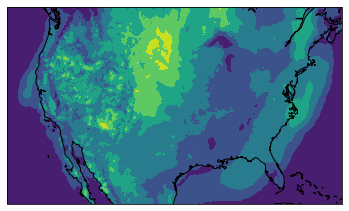

In [19]:
ax = plt.axes(projection=projection)
ax.contourf(std_dev.x, std_dev.y, std_dev)
ax.coastlines()

plt.show()

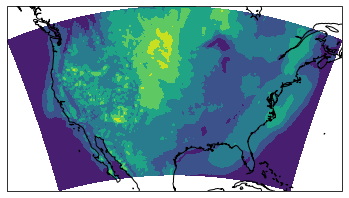

In [21]:
ax = plt.axes(projection=ccrs.Mercator())
ax.contourf(std_dev.x, std_dev.y, std_dev, transform=projection)
ax.coastlines()

plt.show()